In [1]:
import os
import json
import requests
from dotenv import load_dotenv
import plotly_express as px
load_dotenv()

True

In [2]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
api_key = os.getenv("API-KEY")
headers = {"Authorization":
           f"Bearer {api_key}"}

In [4]:
def get_quizzes(course_id, headers):
    """This function returns a list of JSONs
    that include all of the quizzes for a given course
    The main purpose for this function is to find the
    peer mentorship review quizzes we give the students
    but this would return useful data about any quizzes
    we were interested in.
    USAGE:
    This function requires that you have an API predefined.
    Most users won't notice this in the front end as we'll
    build the key into the program. If you're servicing in the
    future headers should look like:
    headers = {"Authorization":f"Bearer {api_key}"}
    jsons = get_quizes(400, headers)
    """
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes", headers=headers)
    raw = r.json()
    for i in raw:
        i["course_id"] = course_id
    return raw

In [5]:
def get_submissions(course_id, quiz_id, headers):
    """Creates a small list of jsons
    that can be made into a file very easily
    then converted to a dataframe for exploration
    This particular design is just for grabbing pagniated
    information from the api and returning it in a useful
    way.
    Usage:
    This function requires that you have an API predefined.
    Most users won't notice this in the front end as we'll
    build the key into the program. If you're servicing in the
    future headers should look like:
    headers = {"Authorization":f"Bearer {api_key}"}
    Example ids used, not real
    jsons = get_submissions(400, 1000)
    with open("some_json_title.json", "w") as outfile:
        json.dump(data_set, outfile)
    """
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions", headers=headers)
    data_set = []
    raw = r.json()

    for submission in raw["quiz_submissions"]:
        submission["course_id"] = course_id
        submission["quiz_id"] = quiz_id
        data_set.append(submission)

    if "next" in r.links.keys():
        while "next" in r.links.keys():
            r = requests.get(r.links["next"]["url"], headers=headers)
            raw = r.json()
            for submission in raw["quiz_submissions"]:
                submission["course_id"] = course_id
                submission["quiz_id"] = quiz_id
                data_set.append(submission)
        if "last" in r.links.keys() and r.links['current']['url'] == r.links['last']['url']:
            print('Done!')
    else:
        print("Just one page!")
    return data_set

In [6]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/accounts/1/courses?search_by=course&search_term=LLP&per_page=100", headers=headers)
r

<Response [200]>

In [7]:
raw = r.json()
raw
#with open("LLP-Courses.json", "w") as outfile:
#    json.dump(raw, outfile)

In [9]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/accounts/1/users", headers=headers)
r

<Response [200]>

In [ ]:
llp_courses_df = pd.read_json("LLP-Courses.json")
llp_courses_df.head()

In [ ]:
llp_no_temp = llp_courses_df[llp_courses_df["course_code"].str.contains("Template")==False]
llp_no_temp.head()

In [ ]:
llp_2011_2010 = llp_no_temp[(llp_no_temp["course_code"].str.contains(pat = "201\d", regex = True))]
llp_2011_2010.head()

In [ ]:
quizzes_data = []
for i in llp_2011_2010["id"]:
    for t in get_quizzes(i, headers):
        quizzes_data.append(t)

In [ ]:
with open("quizzes_llp_201X.json", "w") as outfile:
    json.dump(quizzes_data, outfile)

In [ ]:
quizzes_df = pd.read_json("quizzes_llp_201X.json")
quizzes_df[["id","title", "course_id"]].head()

In [ ]:
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6780/submissions", headers=headers)
data_set = []
raw = r.json()

In [ ]:
for i in raw["quiz_submissions"]:
    i["course_id"] = 495 

In [ ]:
for i in quizzes_df[["id", "course_id"]].itertuples():
    submissions = get_submissions(i.course_id, i.id)
    with open(f"submissions_{i.id}.json", "w") as outfile:
        json.dump(submissions, outfile)

In [ ]:
subs_6585_df = pd.read_json("submissions_6585.json")
subs_6585_df.head()

In [ ]:
course_id = subs_6585_df["course_id"][1]
quiz_id = subs_6585_df["quiz_id"][1]
started_at = subs_6585_df["started_at"][0]
sub_id = subs_6585_df["id"][1]
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers) 

In [ ]:
raw2 = r.json()

for i in raw2["quiz_submission_events"]:
    if "event_data" in i.keys():
        if i["event_type"] == "question_answered":
            for t in i["event_data"]:
                if t["answer"] != None and 0 < t["answer"] < 4:
                    print(t["answer"]) 

In [13]:
import glob
subs_df = pd.DataFrame()
path_to_json = ""
json_pattern = os.path.join(path_to_json, "submissions_*.json")
files_list = glob.glob(json_pattern)

for f in files_list:
    data = pd.read_json(f)
    subs_df = subs_df.append(data)

In [24]:
subs_df.iloc[4906]

id                                                                                                                                 97757
quiz_id                                                                                                                             8562
quiz_version                                                                                                                          53
user_id                                                                                                                             2425
submission_id                                                                                                                     538347
score                                                                                                                                  1
kept_score                                                                                                                             1
started_at                               

In [26]:
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/642/quizzes/8562/submissions/97757/events", headers=headers)
r

<Response [200]>

In [28]:
raw = r.json()
raw

{'quiz_submission_events': [{'id': '1132590',
   'event_type': 'submission_created',
   'event_data': {'quiz_version': 53,
    'quiz_data': [{'answers': [{'weight': 100,
        'text': 'answer_text',
        'id': 2455,
        'numerical_answer_type': 'exact_answer',
        'exact': 1.0,
        'margin': 0.0},
       {'weight': 100,
        'text': 'answer_text',
        'id': 8458,
        'numerical_answer_type': 'exact_answer',
        'exact': 2.0,
        'margin': 0.0},
       {'weight': 100,
        'text': 'answer_text',
        'id': 4060,
        'numerical_answer_type': 'exact_answer',
        'exact': 3.0,
        'margin': 0.0}],
      'correct_comments': '',
      'incorrect_comments': '',
      'question_text': '<div id="t-formula-bar-input-container">\n<div dir="ltr">\n<div id="t-formula-bar-input">\n<p class="cell-input disabled-input" dir="ltr" role="combobox" aria-autocomplete="list">How did your orientation go today?</p>\n<p class="cell-input disabled-input" dir

In [16]:

result_data = []
count = 0
for row in subs_df[["id","user_id","quiz_id","started_at","course_id"]].iterrows():
    sub_id = row[1][0]
    user_id = row[1][1]
    quiz_id = row[1][2]
    started_at = row[1][3]
    course_id = row[1][4]
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers)
    count+=1
    print(count)
    raw = r.json()
    for i in raw["quiz_submission_events"]:
        if "event_data" in i.keys():
            if i["event_type"] == "question_answered":
                for t in i["event_data"]:
                    if t["answer"] != None and isinstance(t["answer"], float):
                        if t["answer"] != None and 0 < t["answer"] < 4:
                            result_data.append([user_id, t["answer"], started_at]) 


884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106


JSONDecodeError: Extra data: line 1 column 5 (char 4)

In [ ]:
result_data[0]

In [12]:
result_df = pd.DataFrame(result_data, columns=["user_id", "score", "started_at"])
result_df = result_df.sort_values("started_at")

In [23]:
fig = px.line(result_df,x="started_at", y="score", color="user_id")
fig.update_traces(mode="markers+lines")
fig.show()

In [ ]:
result_df["user_id"].unique()

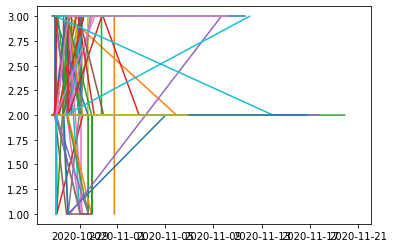

In [21]:
import matplotlib.pyplot as plt
for i in result_df["user_id"].unique():
    df = result_df[result_df["user_id"]==i]
    df = df.sort_values("started_at")
    plt.plot(df["started_at"], df["score"])
#plt.legend(result_df["user_id"].unique())
plt.show()

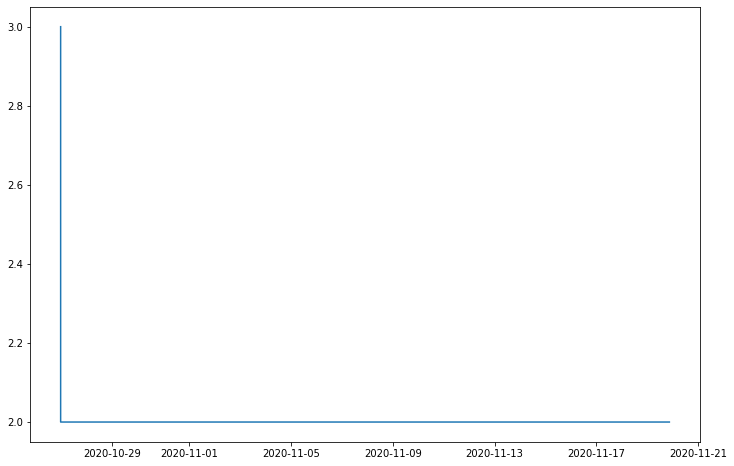

In [20]:
fig = plt.figure(figsize=(12,8))
df = result_df[result_df["user_id"]==1011]
df = df.sort_values("started_at")
plt.plot(df["started_at"], df["score"])
plt.show()

In [19]:
df.sort_values("started_at")

,user_id,score,started_at
516,1011,3.0,2020-10-26 23:10:51+00:00
2,1011,2.0,2020-10-26 23:11:21+00:00
457,1011,2.0,2020-11-19 20:38:41+00:00


In [ ]:
result_pivot = result_df.pivot(index="started_at", columns="user_id", values="score")
result_pivot.plot()

In [ ]:
st_544 = []
for i in result_data:
    if i[0] == 544:
        st_544.append(i)

In [ ]:
st_633 = []
for i in result_data:
    if i[0] == 633:
        st_633.append(i)

In [ ]:
st_544_633 = st_544+st_633
st_544_633

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i[2] for i in st_633], [i[1] for i in st_633])

In [ ]:
counts = {3:0,2:0,1:0}
for i in result_data:
    if i[1] == 1:
        counts[1]+=1
    if i[1] == 2:
        counts[2]+=1
    if i[1] == 3:
        counts[3]+=1
counts

In [ ]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(),counts.values(), color=["green", "grey", "red"])

In [ ]:
result_data
[i for i in result_data if i[0]==633]

In [ ]:
user_633 = course_495[course_495["user_id"]==633]
user_633

In [ ]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions", headers=headers)
r

In [ ]:
raw = r.json()

with open("submissions-6617.json","w") as outfile:
    json.dump(raw["quiz_submissions"], outfile)

In [ ]:
sub_df_6617 = pd.read_json("submissions-6617.json")
sub_df_6617.head()

In [ ]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions/57046/events", headers=headers)
r

In [ ]:
raw = r.json()["quiz_submission_events"]
for i in raw:
    i["user_id"] = 530

In [ ]:
with open("events-57046.json", "w") as outfile:
    json.dump(raw, outfile)

In [ ]:
events_df_57046 = pd.read_json("events-57046.json")
events_df_57046

In [ ]:

def get_answer(df):
    for i in df["event_data"]:
        if isinstance(i, list) and isinstance(i[0], str)==False:
            if "22635" in i[0].values():
                print(i[0]["answer"])
get_answer(events_df_56623)

In [ ]:
course_id = 495
quiz_id = 6780
submission_id = 56623
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{submission_id}/events", headers=headers)
r